# Proyecto APCC : Corrección de errores con redes neuronales

__Guillermo García Patiño Lenza__

In [2]:
import tensorflow_quantum as tfq
import sympy as sp
from cirq import Simulator
import tensorflow as tf
import cirq as cq
import matplotlib.pyplot as plt
import numpy as np
from cirq.contrib.svg import SVGCircuit

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

## Definición de los circuitos con ruido y corrección parametrizados:

In [8]:
    def prodTelepRyC(gradoX, gradoZ, q0val, params):

        # q0 contiene el estado que se quiere enviar
        # q1 es el qubit de Alice
        # q2 es el qubit de Bob

        q0,q1,q2 = cq.GridQubit.rect(1,3)

        mIni = []

        # Se prepara q0 en el estado deseado
        if(q0val == 1):
            mIni.append(cq.Moment([cq.X(q0)]))

        # Entrelazo q1 y q2
        m1 = cq.Moment([cq.H(q1)])
        mIni.append(m1)
        m2 = cq.Moment([cq.CNOT(q1,q2)])
        mIni.append(m2)

        circuitoBase = cq.Circuit(mIni)

        # Codificar el estado de q0 en q1
        circuitoBase.append(cq.CNOT(q0,q1))
        circuitoBase.append(cq.H(q0))

        # Se inserta el ruido a la hora de enviar el bit
        circuitoBase.append(cq.rx(gradoX).on(q1))
        circuitoBase.append(cq.rz(gradoZ).on(q1))

        # Se insertan puertas X y Z para corregir el ruido
        circuitoBase.append(cq.rx(params[0]).on(q1))
        circuitoBase.append(cq.rz(params[1]).on(q1))

        # Decodificar el estado de q0
        circuitoBase.append(cq.CNOT(q1,q2))    
        circuitoBase.append(cq.CZ(q0,q2))


        # medir
        circuitoBase.append([cq.measure(q0), cq.measure(q1), cq.measure(q2)])

        me = []
        if (q0val == 1):
            me.append(cq.Moment([cq.X(q0)]))
        me.append(m1)
        me.append(m2)

        me1 = cq.Moment([cq.CNOT(q0,q1)])
        me.append(me1)
        me2 = cq.Moment([cq.H(q0)])
        me.append(me2)
        me3 = cq.Moment([cq.rx(gradoX).on(q1)])
        me.append(me3)
        me4 = cq.Moment([cq.rz(gradoZ).on(q1)])
        me.append(me4)
        circuitoEntrada = cq.Circuit(me)

        mc1 = cq.Moment([cq.rx(params[0]).on(q1)])
        mc2 = cq.Moment([cq.rz(params[1]).on(q1)])
        mc3 = cq.Moment([cq.CNOT(q1,q2)])
        mc4 = cq.Moment([cq.CZ(q0,q2)])
        mc5 = cq.Moment([cq.measure(q0), cq.measure(q1), cq.measure(q2)])
        circuitoControlado = cq.Circuit([mc1,mc2,mc3,mc4,mc5])

        return circuitoBase, [q0,q1,q2], [circuitoEntrada, circuitoControlado]

(v0, v1)


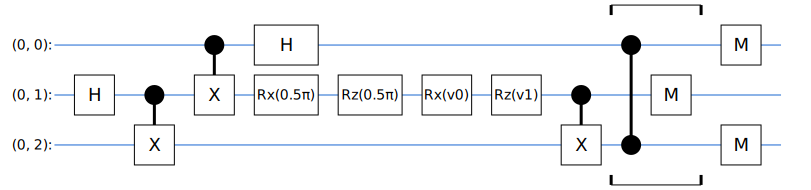

In [9]:
ctr_params = sp.symbols('v0 , v1')
print(ctr_params)
c = prodTelepRyC(0.5* np.pi,0.5 * np.pi,0,ctr_params)
SVGCircuit(c[0])

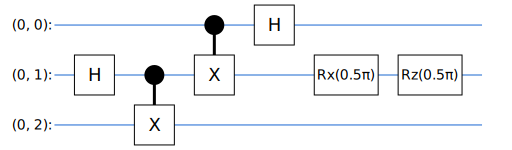

In [10]:
SVGCircuit(c[2][0])

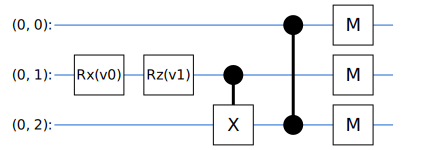

In [11]:
SVGCircuit(c[2][1])

In [12]:
    def prodCodifDensaRyC(gradoX, gradoZ, params,b1,b0):
        #construir la primera parte del circuito

        q0, q1 = cq.GridQubit.rect(1,2)

        ent1 = cq.Moment(cq.H(q0))
        ent2 = cq.Moment([cq.CNOT(q0,q1)])

        circuitBase = cq.Circuit((ent1,ent2))

        # añadirle la parte que realiza la codificacion superdensa
        l = []
        if (b1 == 0 and b0 == 1):
            circuitBase.append(cq.X(q0))
            l.append(cq.Moment([cq.X(q0)]))
        elif (b1 == 1 and b0 == 0):
            circuitBase.append(cq.Z(q0))
            l.append(cq.Moment([cq.Z(q0)]))
        elif (b1 == 1 and b0 == 1):
            circuitBase.append(cq.X(q0))
            circuitBase.append(cq.Z(q0))
            l.append(cq.Moment([cq.X(q0)]))
            l.append(cq.Moment([cq.Z(q0)]))

        # se inserta el ruido

        circuitBase.append(cq.rx(gradoX).on(q0))

        circuitBase.append(cq.rz(gradoZ).on(q0))

        # ----- FIN DEL CIRCUITO DE ENTRADA ----- #

        # se insertan los parámetros para la corrección 

        circuitBase.append(cq.rx(params[0]).on(q0))

        circuitBase.append(cq.rz(params[1]).on(q0))

        # Añadir la decodificacion y la medida

        circuitBase.append(cq.CNOT(q0,q1))

        circuitBase.append(cq.H(q0))

        circuitBase.append([cq.measure(q0),cq.measure(q1)])



        me1 = cq.Moment([cq.rx(gradoX).on(q0)])
        me2 = cq.Moment([cq.rz(gradoZ).on(q0)])
        l2 = [ent1,ent2]
        for i in range(len(l)):
            l2.append(l[i])
        l2.append(me1)
        l2.append(me2)

        circuitoEntrada = cq.Circuit(l2)

        mc1 = cq.Moment([cq.rx(params[0]).on(q0)])
        mc2 = cq.Moment([cq.rz(params[1]).on(q0)])
        mc3 = cq.Moment([cq.CNOT(q0,q1)])
        mc4 = cq.Moment([cq.H(q0)])
        mc5 = cq.Moment([cq.measure(q0),cq.measure(q1)])
        circuitoControlado = cq.Circuit([mc1,mc2,mc3,mc4,mc5])

        return circuitBase, [q0,q1], [circuitoEntrada, circuitoControlado]

(v0, v1)


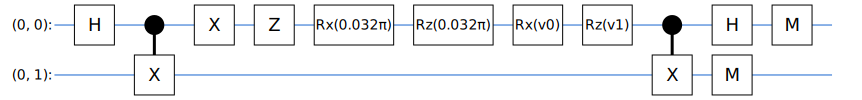

In [13]:
ctr_params = sp.symbols('v0 , v1')
print(ctr_params)
c = prodCodifDensaRyC(0.1,0.1,ctr_params,1,1)
SVGCircuit(c[0])


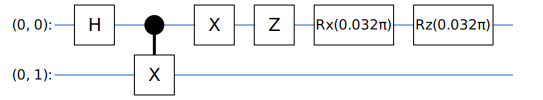

In [14]:
SVGCircuit(c[2][0])

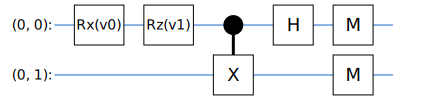

In [15]:
SVGCircuit(c[2][1])

In [19]:
def producirCodifDensaGuess(params):
    q0, q1 = cq.GridQubit.rect(1,2)
    
    l = []
    ent1 = cq.Moment(cq.H(q0))
    ent2 = cq.Moment([cq.CNOT(q0,q1)])
    
    circuitBase = cq.Circuit((ent1,ent2))
    
    l.append(ent1)
    l.append(ent2)
    
    l2 = []
    
    # añadirle la parte que realiza la codificacion superdensa controlada
    #    por redes neuronales
    
    circuitBase.append(cq.rx(params[0]).on(q0))
    circuitBase.append(cq.rz(params[1]).on(q0))
    
    l2.append(cq.Moment([cq.rx(params[0]).on(q0)]))
    l2.append(cq.Moment([cq.rz(params[1]).on(q0)]))
        
    
    # Añadir la decodificacion y la medida
    
    circuitBase.append(cq.CNOT(q0,q1))
    l2.append(cq.Moment([cq.CNOT(q0,q1)]))
    
    circuitBase.append(cq.H(q0))
    l2.append(cq.Moment([cq.H(q0)]))
    
    circuitBase.append([cq.measure(q0),cq.measure(q1)])
    l2.append([cq.measure(q0),cq.measure(q1)])
    
    
    circuitoEntrada = cq.Circuit(l)
    circuitoControlado = cq.Circuit(l2)
    
    
    return circuitBase, [q0,q1], [circuitoEntrada, circuitoControlado]

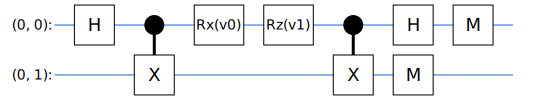

In [20]:
ctr_params = sp.symbols('v0 , v1')
cg = producirCodifDensaGuess(ctr_params)
SVGCircuit(cg[0])

## Simulación con ruido y parámetros de corrección arbitrarios

(array([ 9., 11., 17., 12., 15., 15.,  9., 12.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <BarContainer object of 8 artists>)

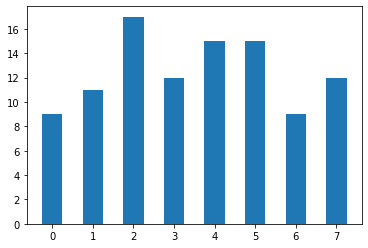

In [21]:
sim = Simulator()
ctr_params = sp.symbols('v0 , v1')
resolver = cq.ParamResolver({ctr_params[0] : 0.5 , ctr_params[1] : 0.5})
c2 = prodTelepRyC(0.5*np.pi, 0.5*np.pi, 1, ctr_params)[0]

vec = np.zeros(100)

for i in range(100):
    res = sim.simulate(c2,resolver,initial_state = 0b000)

    b2 = res.measurements['(0, 2)'][0]
    b1 = res.measurements['(0, 1)'][0]
    b0 = res.measurements['(0, 0)'][0]
    num = b2 + 2*b1 + 4*b0
    vec[i] +=  num

plt.hist(vec, bins = [0,1,2,3,4,5,6,7,8], align = 'left', rwidth = 0.5)

(array([ 2., 11., 13., 74.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

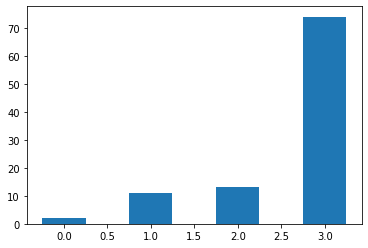

In [22]:
sim = Simulator()
ctr_params = sp.symbols('v0 , v1')
resolver = cq.ParamResolver({ctr_params[0] : 0.5 , ctr_params[1] : 0.5})
c1 = prodCodifDensaRyC(0.3, 0.3, ctr_params, 1, 1)[0]
res = sim.simulate(c1, resolver, initial_state = 0b00)

vec = np.zeros(100)

for i in range(100):
    res = sim.simulate(c1,resolver,initial_state = 0b00)
    b1 = res.measurements['(0, 1)'][0]
    b0 = res.measurements['(0, 0)'][0]
    num = 2*b1 + b0
    vec[i] +=  num

plt.hist(vec,bins = [0,1,2,3,4], align = 'left', rwidth = 0.5)

## Simulación Empleando TensorFlowQuantum

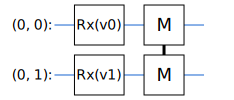

In [115]:
qubit1 = cq.GridQubit.rect(1,2)
cparams = sp.symbols('v0 v1')
mom1 = cq.Moment([cq.rx(cparams[0]).on(qubit1[0]), cq.rx(cparams[1]).on(qubit1[1])])
mom2 = cq.measure(qubit1[0], qubit1[1])
caux = cq.Circuit([mom1, mom2])
SVGCircuit(caux)



In [139]:
valores1 = np.zeros((10,2))
valores2 = np.array(np.random.uniform(0, 2*np.pi, (10,2)), dtype = np.float32)
op = cq.Z(qubit1[0])

r1 = tfq.layers.Expectation()(caux,symbol_names=[cparams[0], cparams[1]], symbol_values=valores1, operators = op)

print(r1)

tf.Tensor(
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)


In [23]:
valores_prueba = np.array(np.random.uniform(0, 2 * np.pi, (10,2)), dtype = np.float32)
no_rotaciones = np.zeros(valores_prueba.shape)
print(valores_prueba)
print(no_rotaciones)

[[3.6866176  2.010756  ]
 [5.425159   1.4186217 ]
 [3.3151512  6.248425  ]
 [1.0881704  0.90634793]
 [2.8308911  0.58349156]
 [3.3768823  3.9559145 ]
 [5.909548   2.3224912 ]
 [3.2387266  4.7208524 ]
 [3.5355732  3.3257535 ]
 [6.2623515  0.23142444]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2)]


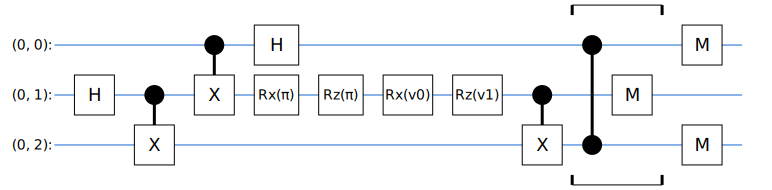

In [25]:
ctr_params = sp.symbols('v0 , v1')
c2, qubits, circuitos = prodTelepRyC(np.pi,np.pi,0, ctr_params)
print(qubits)
SVGCircuit(c2)


In [26]:
circuit_tensor = tfq.convert_to_tensor([c2])
print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [27]:
z = cq.Z(qubits[2])
r = tfq.layers.Expectation()(c2,symbol_names=[ctr_params[0], ctr_params[1]], symbol_values=valores_prueba, operators = z)

print(r)

tf.Tensor(
[[ 0.8551142 ]
 [-0.65393174]
 [ 0.9849764 ]
 [-0.46410686]
 [ 0.95211935]
 [ 0.972447  ]
 [-0.9310055 ]
 [ 0.9952861 ]
 [ 0.9233883 ]
 [-0.99978316]], shape=(10, 1), dtype=float32)


In [34]:
r2 = tfq.layers.Expectation()(c2,symbol_names=[ctr_params[0], ctr_params[1]], symbol_values=no_rotaciones, operators = z)
print(r2)

tf.Tensor(
[[-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]
 [-0.9999999]], shape=(10, 1), dtype=float32)


## Construcción de la red neuronal

### Circuito Controlado

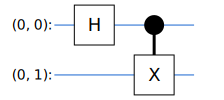

In [140]:
ctr_params = sp.symbols('v0 , v1')
c3, qubits3, partes = producirCodifDensaGuess(ctr_params)
entrada = partes[0]
controlado = partes[1]
SVGCircuit(entrada)

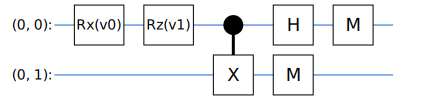

In [141]:
SVGCircuit(controlado)

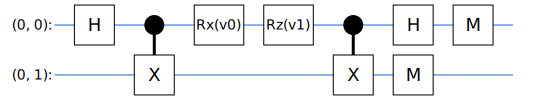

In [156]:
SVGCircuit(c3)

## Construcción y entrenamiento del modelo

### Para la codificación superdensa

In [142]:
    def construirModeloCSD(ruidoX, ruidoZ):
        #---- Definición del Modelo ----#

        # Construccion de circuitos de entrada / controlado
        ctr_params = sp.symbols('v0 , v1')
        c, qubits, partes = prodCodifDensaRyC(ruidoX, ruidoX , ctr_params, 1, 1)

        entrada = partes[0]
        controlado = partes[1]

        # Configuracion del controlador
        controller = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation = 'elu'),
            tf.keras.layers.Dense(2)
        ])

        # Configuracion de las entrads
        circuito_entrada = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuito_entrada')
        comandos_entrada = tf.keras.Input(shape = (1,), dtype = tf.dtypes.float32, name = 'entrada_comandos')

        # Crear el controlador
        capa1 = controller(comandos_entrada)

        # Operador para medir 
        z2 = 2 * cq.Z(qubits[1]) + cq.Z(qubits[0])

        # Configurar la capa de salida
        capaExpected = tfq.layers.ControlledPQC(controlado, operators = z2)

        # Crear la capa de salida
        calculo_expected = capaExpected([circuito_entrada, capa1])

        # Configurar el modelo
        modelo = tf.keras.Model(inputs = [circuito_entrada, comandos_entrada], outputs = calculo_expected)

        #---- Entrenamiento del Modelo ----#

        # Configurar Comandos
        # Se busca generar un 1 con el comando 1 -> No tiene sentido generar un 0
        comandos = np.array([[11]], dtype = np.float32)
        salidas_esperadas = np.array([[-3]], dtype = np.float32)

        # Generar un tensor con los 2 circuitos de entrada (una para cada entrada)
        generador_datos = tfq.convert_to_tensor([entrada])

        # Entrenar el modelo
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)
        loss = tf.keras.losses.MeanSquaredError()
        modelo.compile(optimizer = optimizer, loss = loss)
        history = modelo.fit( x = [generador_datos, comandos], y = salidas_esperadas, epochs = 50000, verbose = 0)

        plt.plot(history.history['loss'])
        plt.title(" Resultados de codificacion superdensa ")
        plt.xlabel("Iteraciones")
        plt.ylabel("Error")
        plt.show()

        print(controller(tf.constant([[1]])))

        print(controller(tf.constant([[1]])).numpy())
        ar = controller(tf.constant([[1]])).numpy()

        print("El error final es {}".format(history.history['loss'][-1]))

        return c, ctr_params, ar

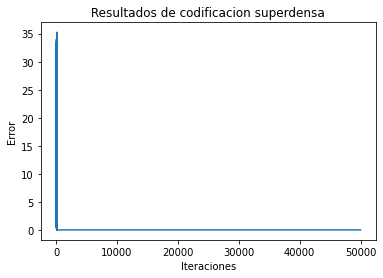

tf.Tensor([[3.0991325 3.1045344]], shape=(1, 2), dtype=float32)
[[3.0991325 3.1045344]]
El error final es 3.4792014957929496e-07


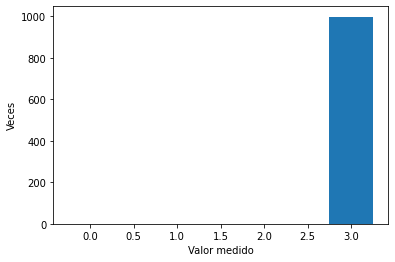

In [144]:
m = construirModeloCSD(3,3)
c = m[0]
ctr_params = m[1]
ar = m[2]

for i in range(ar.shape[0]):
    p0 = ar[i][0]
    p1 = ar[i][1]
    
    simulator = cq.Simulator()
    resolver = cq.ParamResolver({ctr_params[0] : p0 , ctr_params[1] : p1})
    
    res = []
    
    for i in range(1000):
        r = simulator.simulate(c, resolver)
        b0 = r.measurements['(0, 0)'][0]
        b1 = r.measurements['(0, 1)'][0]
        res.append(2*b1 + b0)
        
    plt.figure()
    plt.hist(res,bins = [0,1,2,3,4], align = 'left', rwidth = 0.5)
    plt.xlabel("Valor medido")
    plt.ylabel("Veces")
    plt.show()

In [153]:
    def construirModeloGCSD():
        #---- Definición del Modelo ----#

        # Construccion de circuitos de entrada / controlado
        ctr_params = sp.symbols('v0 , v1')
        c, qubits, partes = producirCodifDensaGuess(ctr_params)

        entrada = partes[0]
        controlado = partes[1]

        # Configuracion del controlador
        controller = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation = 'elu'),
            tf.keras.layers.Dense(2)
        ])

        # Configuracion de las entrads
        circuito_entrada = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuito_entrada')
        comandos_entrada = tf.keras.Input(shape = (1,), dtype = tf.dtypes.float32, name = 'entrada_comandos')

        # Crear el controlador
        capa1 = controller(comandos_entrada)

        # Operador para medir 
        z2 = 2*cq.Z(qubits[1]) + cq.Z(qubits[0])

        # Configurar la capa de salida
        capaExpected = tfq.layers.ControlledPQC(controlado, operators = z2)

        # Crear la capa de salida
        calculo_expected = capaExpected([circuito_entrada, capa1])

        # Configurar el modelo
        modelo = tf.keras.Model(inputs = [circuito_entrada, comandos_entrada], outputs = calculo_expected)

        #---- Entrenamiento del Modelo ----#

        # Configurar Comandos y salidas para cada comando
        comandos = np.array([[0],[1],[10],[11]], dtype = np.float32)
        salidas_esperadas = np.array([[3],[1],[-1],[-3]], dtype = np.float32)

        # Generar un tensor con los 4 circuitos de entrada (una para cada entrada)
        generador_datos = tfq.convert_to_tensor([entrada]*4)

        # Entrenar el modelo
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)
        loss = tf.keras.losses.MeanSquaredError()
        modelo.compile(optimizer = optimizer, loss = loss)
        history = modelo.fit( x = [generador_datos, comandos], y = salidas_esperadas, epochs = 50000, verbose = 0)

        plt.plot(history.history['loss'])
        plt.title(" Resultados de codificacion superdensa ")
        plt.xlabel("Iteraciones")
        plt.ylabel("Error")
        plt.show()

        print(controller(tf.constant([[0],[1],[10],[11]])).numpy())
        ar = controller(tf.constant([[0],[1],[10],[11]])).numpy()

        print("El error final es {}".format(history.history['loss'][-1]))
        return c, ctr_params, ar

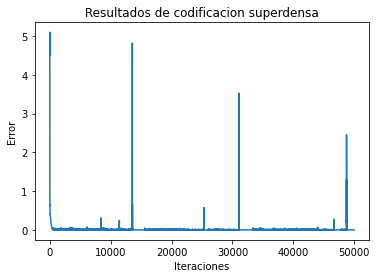

[[-1.23838186e-02  1.12730265e-02]
 [-5.03219783e-01 -8.70517540e+00]
 [ 2.50757837e+00 -1.97641029e+01]
 [ 3.07125711e+00 -2.18992691e+01]]
El error final es 2.138580020982772e-05
ar = [[-1.23838186e-02  1.12730265e-02]
 [-5.03219783e-01 -8.70517540e+00]
 [ 2.50757837e+00 -1.97641029e+01]
 [ 3.07125711e+00 -2.18992691e+01]]


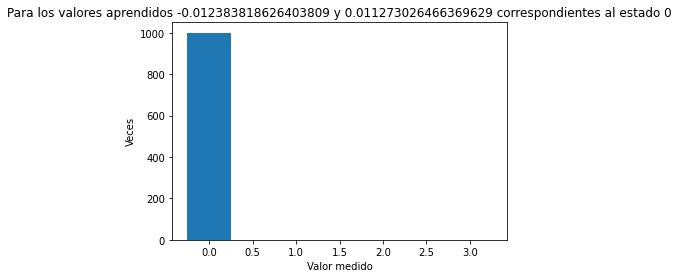

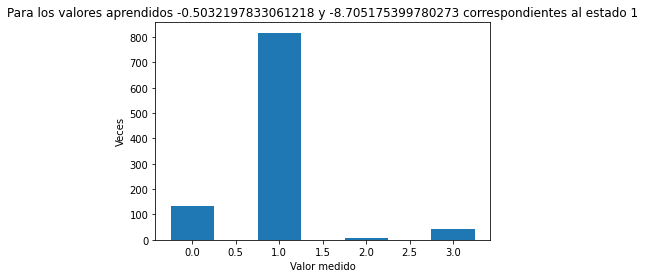

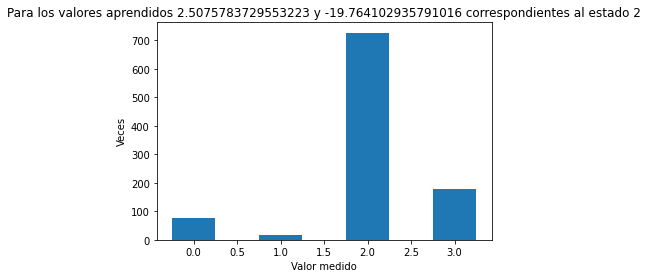

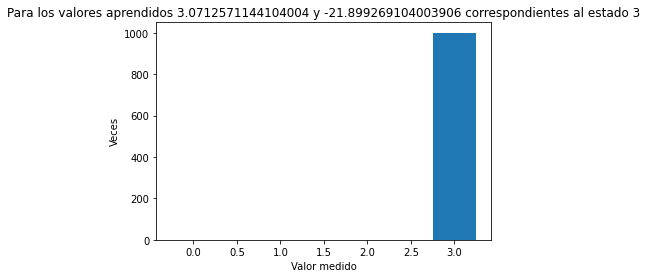

In [155]:
m = construirModeloGCSD()
c = m[0]
ctr_params = m[1]
ar = m[2]

print("ar = {}".format(ar))

for i in range(ar.shape[0]):
    p0 = ar[i][0]
    p1 = ar[i][1]
    
    simulator = cq.Simulator()
    resolver = cq.ParamResolver({ctr_params[0] : p0 , ctr_params[1] : p1})
    
    res = []
    for j in range(1000):
        r = simulator.simulate(c, resolver)
        b0 = r.measurements['(0, 0)'][0]
        b1 = r.measurements['(0, 1)'][0]
        res.append(2*b1 + b0)
    
    plt.figure()
    plt.hist(res,bins = [0,1,2,3,4], align = 'left', rwidth = 0.5)
    plt.xlabel("Valor medido")
    plt.ylabel("Veces")
    plt.title("Para los valores aprendidos {} y {} correspondientes al estado {}".format(p0,p1,i))
    

### Para la teleportación cuántica

In [16]:
    def construirModeloTPC(ruidoX, ruidoZ, valq0):
        #---- Definición del Modelo ----#

        # Construccion de circuitos de entrada / controlado
        ctr_params = sp.symbols('v0 , v1')
        c, qubits, partes = prodTelepRyC(ruidoX,ruidoZ,valq0,ctr_params)

        entrada = partes[0]
        controlado = partes[1]

        # Configuracion del controlador
        controller = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation = 'elu'),
            tf.keras.layers.Dense(2)
        ])

        # Configuracion de las entrads
        circuito_entrada = tf.keras.Input(shape = (), dtype = tf.string, name = 'circuito_entrada')
        comandos_entrada = tf.keras.Input(shape = (1,), dtype = tf.dtypes.float32, name = 'entrada_comandos')

        # Crear el controlador
        capa1 = controller(comandos_entrada)

        # Operador para medir 
        z2 = cq.Z(qubits[2])

        # Configurar la capa de salida
        capaExpected = tfq.layers.ControlledPQC(controlado, operators = z2)

        # Crear la capa de salida
        calculo_expected = capaExpected([circuito_entrada, capa1])

        # Configurar el modelo
        modelo = tf.keras.Model(inputs = [circuito_entrada, comandos_entrada], outputs = calculo_expected)

        # Configurar Comandos
        # Se busca generar un 1 con el comando 1 -> No tiene sentido generar un 0
        comandos = np.array([[1]], dtype = np.float32)
        salidas_esperadas = np.array([[-1]], dtype = np.float32)

        # Generar un tensor con los 2 circuitos de entrada (una para cada entrada)
        generador_datos = tfq.convert_to_tensor([entrada])

        #---- Entrenamiento del Modelo ----#

        # Entrenar el modelo
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
        loss = tf.keras.losses.MeanSquaredError()
        modelo.compile(optimizer = optimizer, loss = loss)
        history = modelo.fit( x = [generador_datos, comandos], y = salidas_esperadas, epochs = 1000, verbose = 0)

        plt.plot(history.history['loss'])
        plt.title(" Resultados de teleportacion cuantica ")
        plt.xlabel("Iteraciones")
        plt.ylabel("Error")
        plt.show()

        print(controller(tf.constant([[1]])).numpy())
        ar = controller(tf.constant([[1]])).numpy()

        print("El error final es {}".format(history.history['loss'][-1]))

        return c, ctr_params, ar

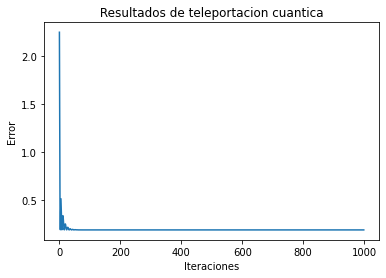

[[ 2.4037066 18.112192 ]]
El error final es 0.19143785536289215


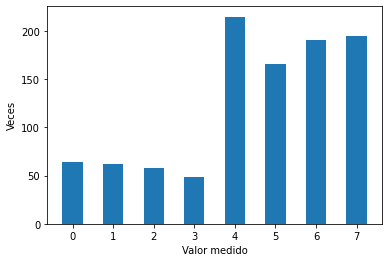

In [20]:
m = construirModeloTPC(2,2,1)
c = m[0]
ctr_params = m[1]
ar = m[2]

for i in range(ar.shape[0]):
    p0 = ar[i][0]
    p1 = ar[i][1]
    
    simulator = cq.Simulator()
    resolver = cq.ParamResolver({ctr_params[0] : p0 , ctr_params[1] : p1})
    
    res = []
    
    for i in range(1000):
        r = simulator.simulate(c, resolver)
        b0 = r.measurements['(0, 0)'][0]
        b1 = r.measurements['(0, 1)'][0]
        b2 = r.measurements['(0, 2)'][0]
        res.append(4*b2 + 2*b1 + b0)
        
    plt.figure()
    plt.hist(res,bins = [0,1,2,3,4,5,6,7,8], align = 'left', rwidth = 0.5)
    plt.xlabel("Valor medido")
    plt.ylabel("Veces")
    plt.show()

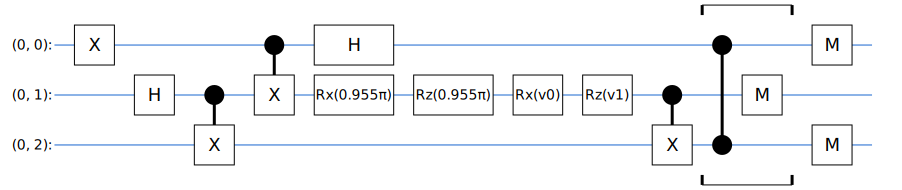

In [161]:
SVGCircuit(c)